In [36]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import keras
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Conv1D,Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [37]:
train = pd.read_csv('/content/drive/My Drive/Module 3/Project/database/topic_identification_data.csv')

In [38]:
train.head()

,comment_text,obscenity,violence,verbal_abuse,identity_hate,hate,offense,neither
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [130]:
#preprocessing 
train['comment_text'].fillna('fillna')
x_train=train['comment_text'].str.lower()
y_train=train[[ "obscenity", "violence", "verbal_abuse", "identity_hate","hate","offense",'neither']].values

In [91]:
#embedding layer 
embed_size=100
max_features=20000
max_len=100

In [92]:
#process the traiing set
tokenizer= Tokenizer(num_words=max_features,lower= True)
tokenizer.fit_on_texts(list(x_train))
tokenized_train=tokenizer.texts_to_sequences(x_train)
train_x=pad_sequences(tokenized_train,maxlen=max_len)

In [93]:
batch_size=128
epochs = 2

In [131]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [134]:
# BEST MODEL with 88 % of accuracy 
inp = Input(shape=(max_len,))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(50, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(7, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [135]:
history = model.fit(train_x,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1)

Epoch 1/2
1297/1297 [==============================] - 170s 131ms/step - loss: 0.4203 - accuracy: 0.9284 - val_loss: 0.5987 - val_accuracy: 0.8555
Epoch 2/2
1297/1297 [==============================] - 174s 134ms/step - loss: 0.2264 - accuracy: 0.9551 - val_loss: 0.6262 - val_accuracy: 0.8411


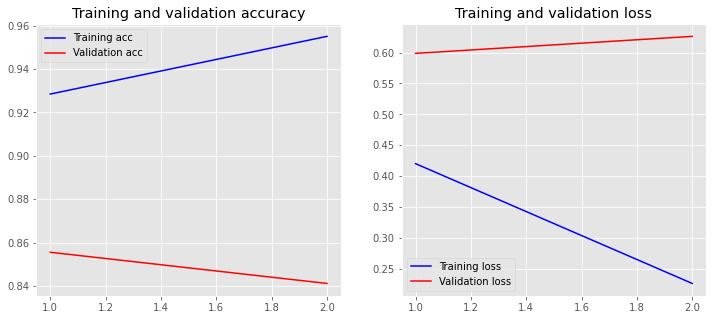

In [136]:
plot_history(history)

In [137]:
# save the model 
model.save('/content/drive/My Drive/Module 3/Project/database/topic_identifier_model.h5')

In [118]:
def preprocess_test(x_test):
  """ this function allows to preprocess the test sentence

      params : 
      x_test (string) : the test message

      return :
      test_x (vector) : the processed test message 
  """
  max_features=20000  
  max_len=100

  train = pd.read_csv('/content/drive/My Drive/Module 3/Project/database/topic_identification_data.csv')
  train['comment_text'].fillna('fillna')
  x_train=train['comment_text'].str.lower()

  x_test = x_test.lower()
  x_test = [x_test]
  tokenizer= Tokenizer(num_words=max_features,lower= True)
  tokenizer.fit_on_texts(list(x_train))
  tokenized_test=tokenizer.texts_to_sequences(x_test)
  test_x=pad_sequences(tokenized_test,maxlen=max_len)

  return test_x

In [138]:
# load the model 
topic_identifier_model =  tf.keras.models.load_model('/content/drive/My Drive/Module 3/Project/database/topic_identifier_model.h5')

In [141]:
#predict the topic 
#preprocess the sentence
x_test = "you gay boy"
test_x = preprocess_test(x_test)
print(test_x)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    6
   453 1080]]


In [144]:
topic_pred = topic_identifier_model.predict(test_x)

In [146]:
label_dict = {0: "obscenity", 1: "violence", 2: "verbal abuse", 3: "identity hate crime", 4: "hate crime", 5: "offense", 6: "neither"}

In [127]:
twitter_rules = "https://help.twitter.com/en/rules-and-policies#general-policies"

In [128]:
policies_dict = {0 : "https://help.twitter.com/en/safety-and-security/offensive-tweets-and-content", 
                 1 : "https://help.twitter.com/en/rules-and-policies/violent-threats-glorification",
                 2 : "https://help.twitter.com/en/rules-and-policies/abusive-behavior",
                 3 : "https://help.twitter.com/en/rules-and-policies/hateful-conduct-policy",
                 4 : "https://help.twitter.com/en/rules-and-policies/hateful-conduct-policy",
                 5 : "https://help.twitter.com/en/safety-and-security/offensive-tweets-and-content"}

In [129]:
#get the prediction 
# if the tweet contains sensitive topics 
if topic_pred.argmax(1)[0]!=6 :
  print("Your tweet may contain sentences that promote " + label_dict[topic_pred.argmax(1)[0]]+ " with  "+str(topic_pred[0][topic_pred.argmax(1)[0]]*100) +" % confidence")
  print("Please review  Twitter Rules and policies: "+ twitter_rules)
  print("And Twiiter's "+ label_dict[topic_pred.argmax(1)[0]] + " policy: "+ policies_dict[topic_pred.argmax(1)[0]])

Your tweet may contain sentences that promote identity hate crime with  46.38248085975647 % confidence
Please review  Twitter Rules and policies: https://help.twitter.com/en/rules-and-policies#general-policies
And Twiiter's identity hate crime policy: https://help.twitter.com/en/rules-and-policies/hateful-conduct-policy
